In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
male_df = male_df.query('age<100')

In [7]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)


In [8]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [9]:
long_data = m_norm.copy()

In [10]:
## MI for age in longtogeny

In [11]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_long = MIR(X,y)

In [12]:
long_indx = np.argsort(mi_score_long)[::-1][0:len(keep_syllables)] # syllble index
impsyl_long= list(long_data.columns[long_indx]) #syllable id
top_mi_score_long = mi_score_long[long_indx]
imp_long = np.array(['n']*len(mi_score_long))
imp_long[np.array(long_indx)]='y'

In [13]:
print('10 most informative syllables for longtogeny: ',impsyl_long)

10 most informative syllables for longtogeny:  [50, 42, 62, 18, 69, 13, 90, 97, 79, 11, 23, 16, 5, 6, 12, 32, 84, 83, 36, 70, 74, 33, 4, 25, 63, 77, 73, 59, 71, 76, 67, 98, 39, 54, 9, 68, 44, 2, 7, 53, 30, 66, 64, 27, 52, 60, 85, 49, 55, 61, 10, 17, 14, 41, 24, 95, 0, 93]


In [14]:
## MI for identity in longtogeny

In [15]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('mouse'))
mi_score_id = MIC(X,y)

In [16]:
id_indx = np.argsort(mi_score_id)[::-1][0:len(keep_syllables)] # syllble index
impsyl_id= list(long_data.columns[id_indx]) #syllable id
top_mi_score_id = mi_score_id[id_indx]
imp_id = np.array(['n']*len(mi_score_id))
imp_id[np.array(id_indx)]='y'

In [17]:
print('10 most informative syllables for identity: ',impsyl_id)

10 most informative syllables for identity:  [95, 71, 83, 11, 67, 0, 93, 44, 62, 68, 54, 10, 74, 49, 53, 64, 90, 39, 85, 17, 36, 66, 30, 73, 41, 70, 27, 52, 77, 2, 4, 79, 42, 98, 69, 23, 24, 5, 61, 6, 60, 14, 59, 7, 12, 13, 76, 55, 9, 16, 32, 97, 33, 63, 18, 25, 50, 84]


In [18]:
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_id,mi_score_long))
mi_df['syll'] = np.concatenate((np.array(long_data.columns),np.array(long_data.columns)))
mi_df['exp'] = ['id']*len(long_data.columns)+['long']*len(long_data.columns)
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()

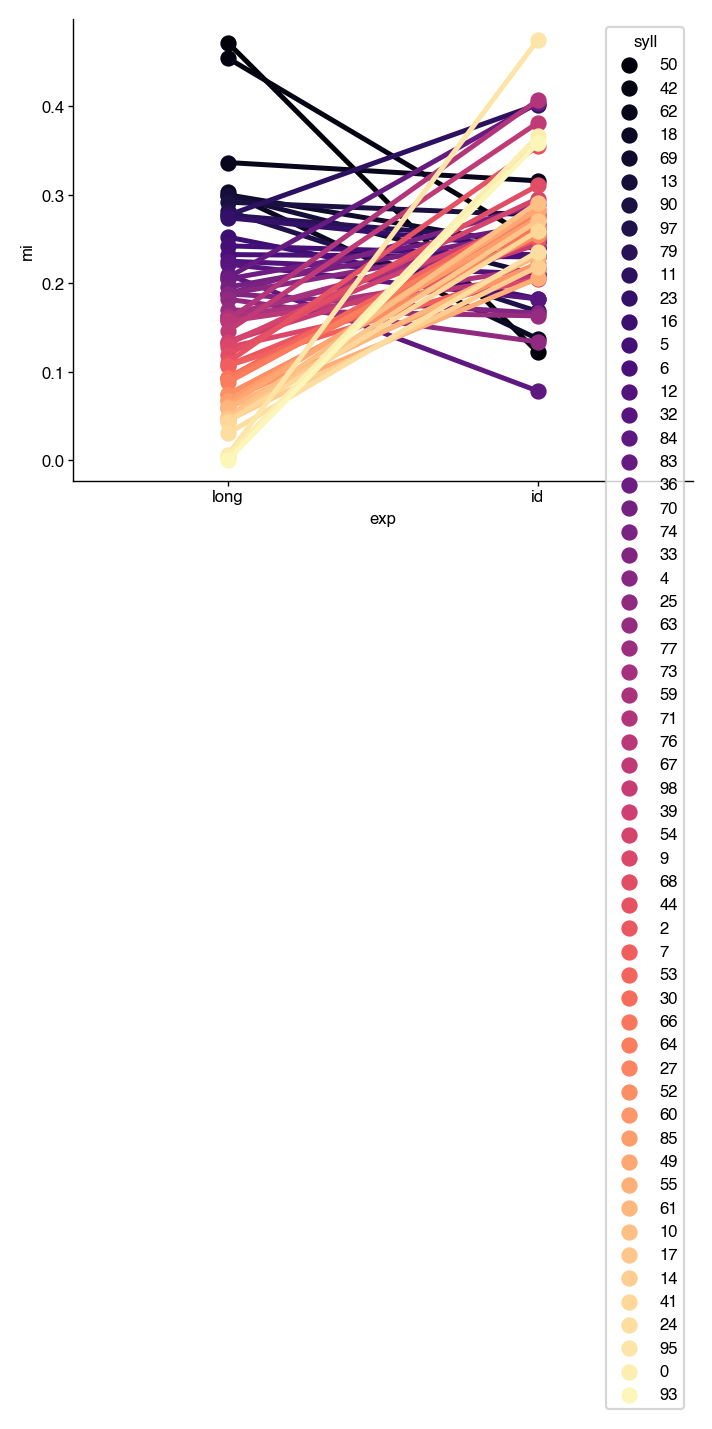

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

#sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',hue_order=impsyl_id)
sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True, palette='magma',order = ['long','id'], hue_order=impsyl_long)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_MI_aging_vs_indv_resampled.pdf')

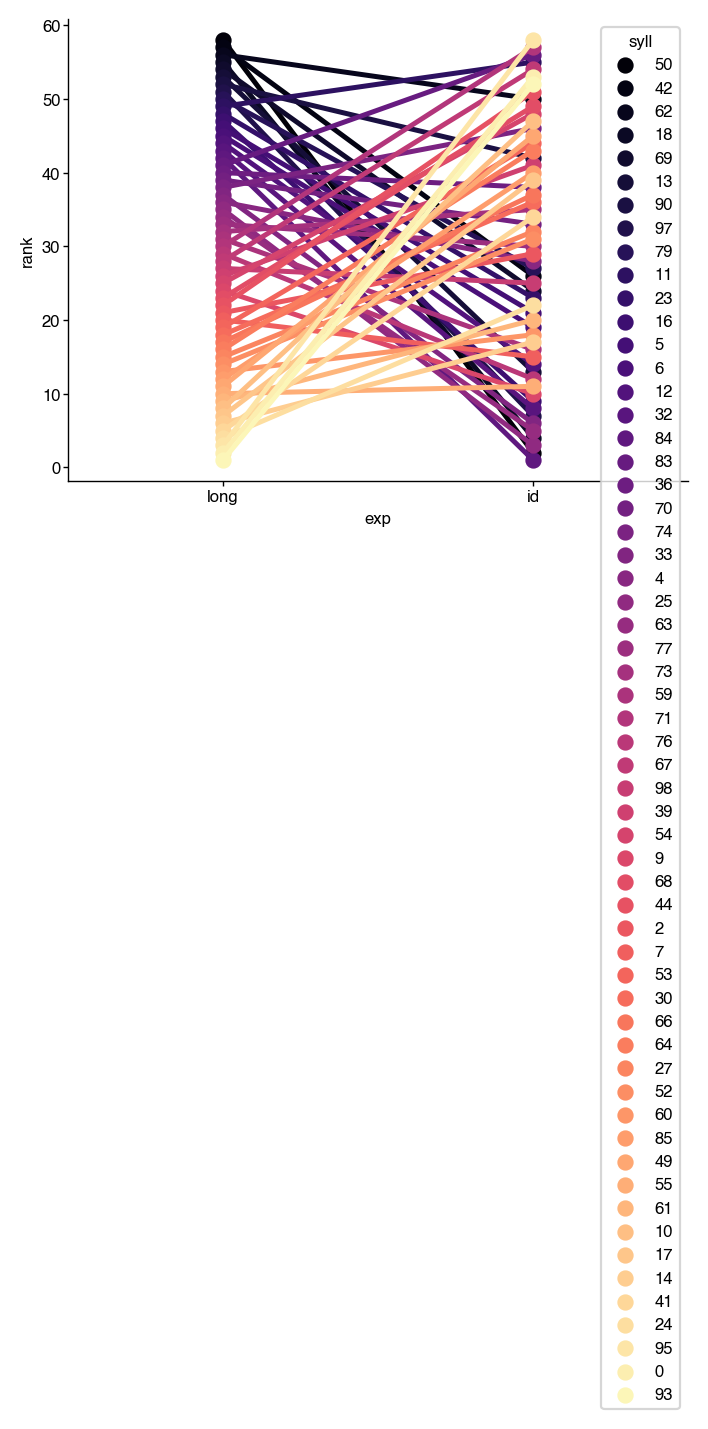

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

#sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',hue_order=impsyl_id)
sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',order = ['long','id'], hue_order=impsyl_long)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_MI_aging_vs_indv_point_RANK_resampled.pdf')

In [21]:
## plot example for 3 syllables with highest age MI across life for 4 mice
n=3
df_age = long_data[impsyl_long[0:n]]

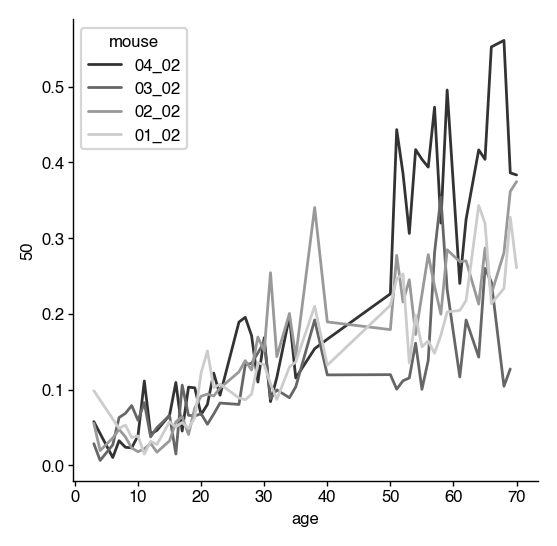

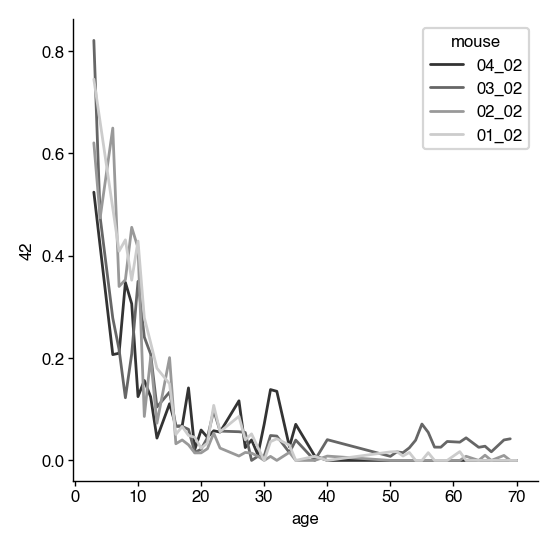

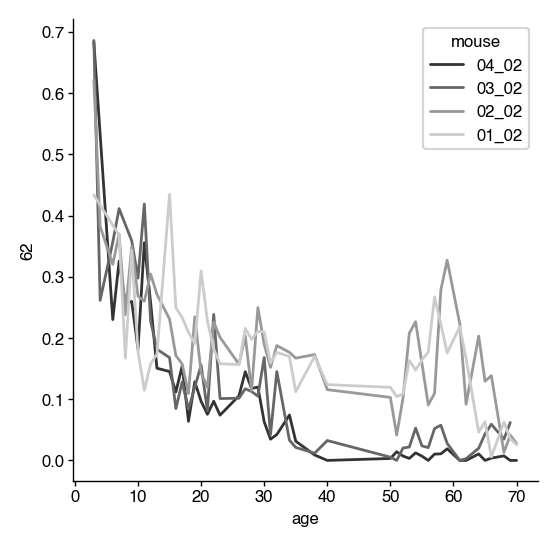

In [22]:
for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(3,3) 
    sns.lineplot(data=df_age,x='age',y=impsyl_long[i],hue='mouse',marker='none',
                 palette = 'gray',
             hue_order=['04_02','03_02','02_02','01_02'],
             #hue_order=['01_01','01_02','01_03','01_04'],
             legend=True)
    sns.despine()
    fig.savefig(c.dana_save_path / "fig4"/ ('exp_MI_aging_resampled_'+str(impsyl_long[i])+'.pdf'))

In [23]:
## plot example for 3 syllables with highest id MI across life for 4 mice
n=3
df_age = long_data[impsyl_id[0:n]]

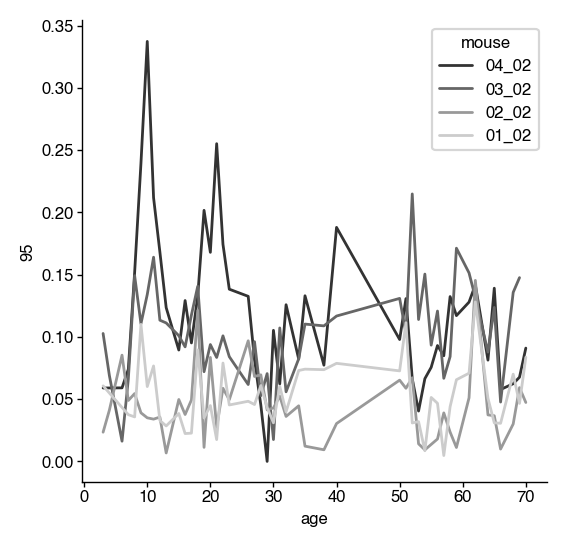

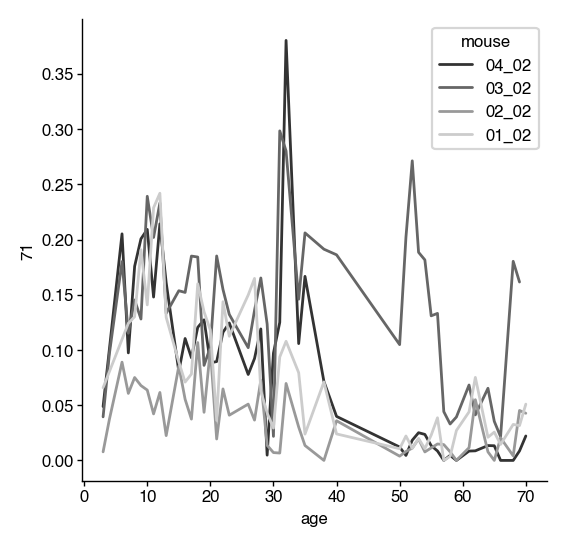

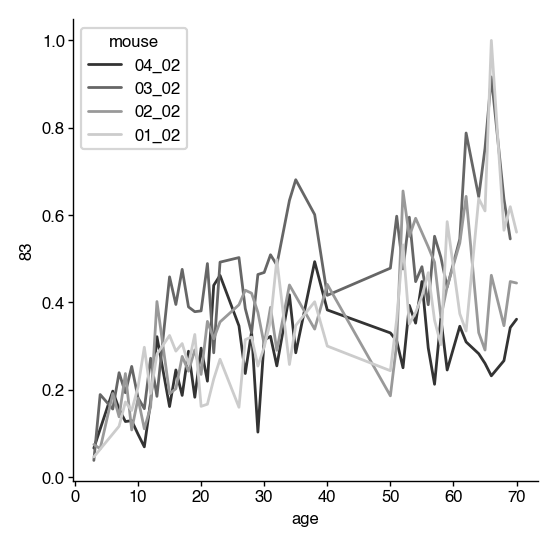

In [24]:
for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(3,3) 
    sns.lineplot(data=df_age,x='age',y=impsyl_id[i],hue='mouse',marker='none',
                 palette = 'gray',
             hue_order=['04_02','03_02','02_02','01_02'],
             #hue_order=['01_01','01_02','01_03','01_04'],
             legend=True)
    sns.despine()
    fig.savefig(c.dana_save_path / "fig4"/ ('exp_MI_id_resampled_'+str(impsyl_id[i])+'.pdf'))